In [2]:
# Cell 1 — Load C-MAPSS FD001 (train)
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]  # notebooks/ -> project root
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "cmapss" / "CMAPSSData"
train_path = DATA_DIR / "train_FD001.txt"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR exists:", DATA_DIR.exists(), "->", DATA_DIR)
print("train_path exists:", train_path.exists(), "->", train_path)

df = pd.read_csv(train_path, sep=r"\s+", header=None, engine="python")
df = df.dropna(axis=1, how="all")  # если вдруг пустая колонка в конце

cols = ["unit_id", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]
assert df.shape[1] == len(cols), f"Unexpected columns: {df.shape[1]} (expected {len(cols)})"
df.columns = cols

df.head(), df.shape


PROJECT_ROOT: /Users/nikitamarshchonok/Desktop/Predictive Maintenance
DATA_DIR exists: True -> /Users/nikitamarshchonok/Desktop/Predictive Maintenance/data/raw/cmapss/CMAPSSData
train_path exists: True -> /Users/nikitamarshchonok/Desktop/Predictive Maintenance/data/raw/cmapss/CMAPSSData/train_FD001.txt


(   unit_id  cycle     op1     op2    op3      s1      s2       s3       s4  \
 0        1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
 1        1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
 2        1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
 3        1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
 4        1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
 
       s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
 0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
 1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
 2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
 3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
 4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
 
      s20      s21  
 0  39.06  23.4190  
 1  39.00  23.4236  
 2 

In [3]:
# Cell 2 — Build RUL target + sanity checks
import numpy as np

# сколько циклов у каждого двигателя
max_cycle = df.groupby("unit_id")["cycle"].max()

# RUL = max_cycle(unit) - current_cycle
df["RUL"] = df["unit_id"].map(max_cycle) - df["cycle"]

print("Units:", df["unit_id"].nunique())
print("Cycle min/max:", int(df["cycle"].min()), int(df["cycle"].max()))
print("RUL min/max:", int(df["RUL"].min()), int(df["RUL"].max()))

# проверим первые и последние точки одного двигателя
u = int(df["unit_id"].iloc[0])
tmp = df[df["unit_id"] == u][["unit_id", "cycle", "RUL"]]
print("\nFirst 3 rows for unit", u)
print(tmp.head(3))
print("\nLast 3 rows for unit", u)
print(tmp.tail(3))

df[["unit_id", "cycle", "RUL"]].head()


Units: 100
Cycle min/max: 1 362
RUL min/max: 0 361

First 3 rows for unit 1
   unit_id  cycle  RUL
0        1      1  191
1        1      2  190
2        1      3  189

Last 3 rows for unit 1
     unit_id  cycle  RUL
189        1    190    2
190        1    191    1
191        1    192    0


,unit_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


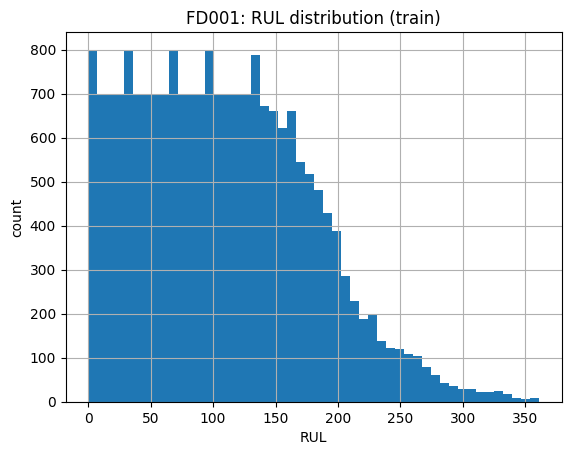

5 lowest-variance sensors (almost constant):
s1     0.000000e+00
s19    0.000000e+00
s18    0.000000e+00
s10    0.000000e+00
s16    3.469531e-18
dtype: float64

5 highest-variance sensors:
s17     1.548763
s3      6.131150
s4      9.000605
s14    19.076176
s9     22.082880
dtype: float64

Low-variance sensors count (<1e-3 std): 6
Low-variance sensors: ['s1', 's19', 's18', 's10', 's16', 's5']


In [4]:
# Cell 3 — EDA: RUL distribution + low-variance sensors
import matplotlib.pyplot as plt

sensor_cols = [c for c in df.columns if c.startswith("s")]

# 1) Гистограмма RUL
plt.figure()
df["RUL"].hist(bins=50)
plt.xlabel("RUL")
plt.ylabel("count")
plt.title("FD001: RUL distribution (train)")
plt.show()

# 2) Вариативность сенсоров (std по всему датасету)
stds = df[sensor_cols].std().sort_values()

print("5 lowest-variance sensors (almost constant):")
print(stds.head(5))

print("\n5 highest-variance sensors:")
print(stds.tail(5))

# Возьмём список сенсоров, которые почти константа (порог можно потом настроить)
low_var = stds[stds < 1e-3].index.tolist()
print(f"\nLow-variance sensors count (<1e-3 std): {len(low_var)}")
print("Low-variance sensors:", low_var)


Using sensors for model: 15
Dropped sensors: ['s1', 's10', 's16', 's18', 's19', 's5']


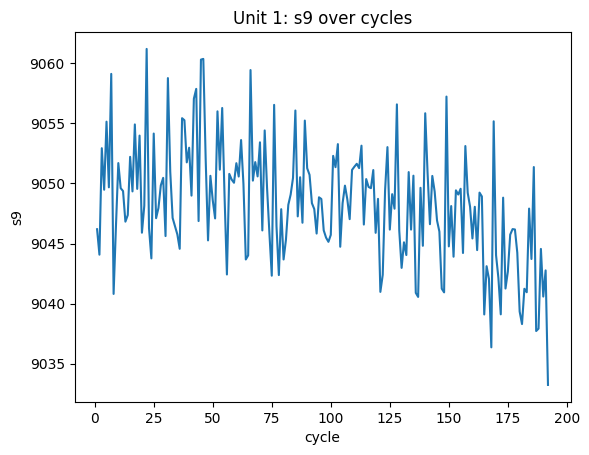

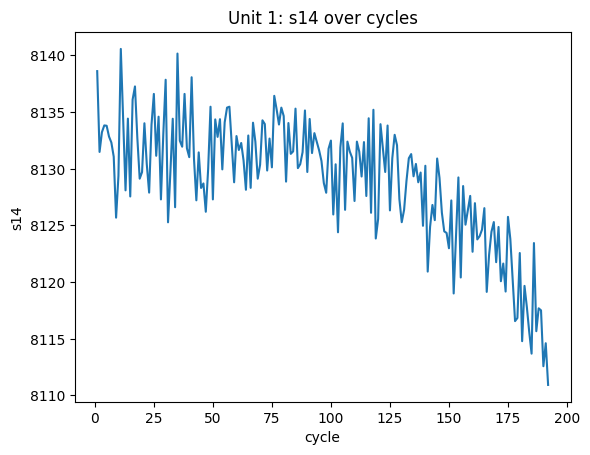

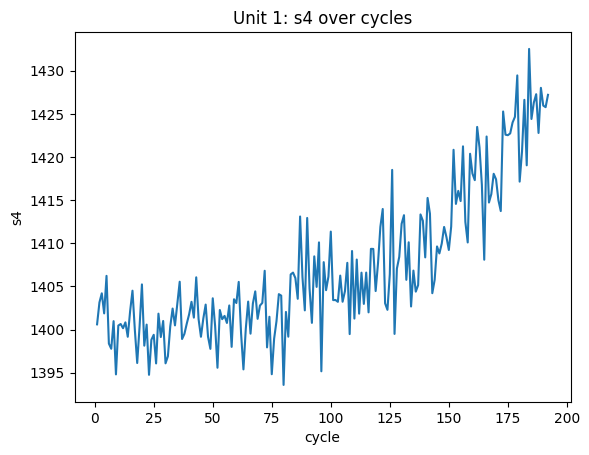

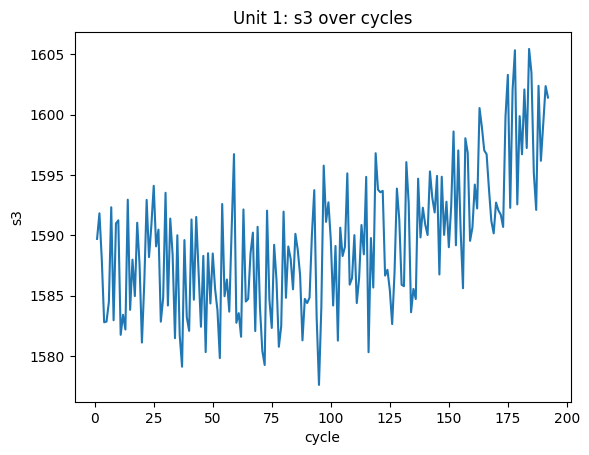

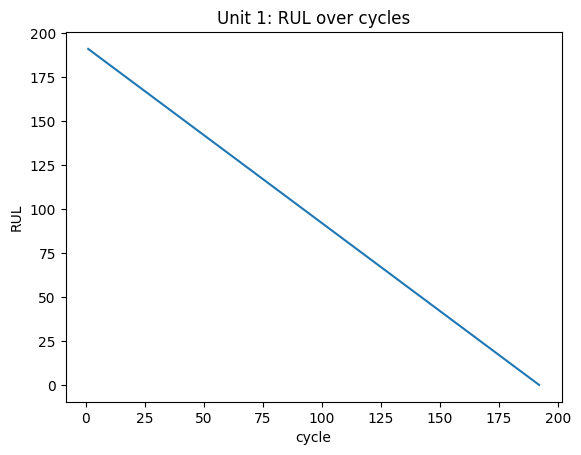

In [5]:
# Cell 4 — Plot a few informative sensors vs cycle for one unit
import matplotlib.pyplot as plt

# сенсоры для моделирования: убираем почти константные
drop_sensors = set(["s1", "s5", "s10", "s16", "s18", "s19"])
model_sensors = [c for c in sensor_cols if c not in drop_sensors]

print("Using sensors for model:", len(model_sensors))
print("Dropped sensors:", sorted(list(drop_sensors)))

# выберем один двигатель (можешь поменять на любой id)
unit = 1
d = df[df["unit_id"] == unit].sort_values("cycle")

# возьмём топ-3 по variance (из твоих: s9, s14, s4) + ещё один для разнообразия (s3)
plot_sensors = ["s9", "s14", "s4", "s3"]

for s in plot_sensors:
    plt.figure()
    plt.plot(d["cycle"], d[s])
    plt.xlabel("cycle")
    plt.ylabel(s)
    plt.title(f"Unit {unit}: {s} over cycles")
    plt.show()

# Также посмотрим, как падает RUL по циклам (sanity)
plt.figure()
plt.plot(d["cycle"], d["RUL"])
plt.xlabel("cycle")
plt.ylabel("RUL")
plt.title(f"Unit {unit}: RUL over cycles")
plt.show()


Train rows: (16561, 18)  Val rows: (4070, 18)
Unique units in train/val: 80 / 20

Baseline RandomForest (RUL capped at 125)
MAE : 12.436
RMSE: 17.085


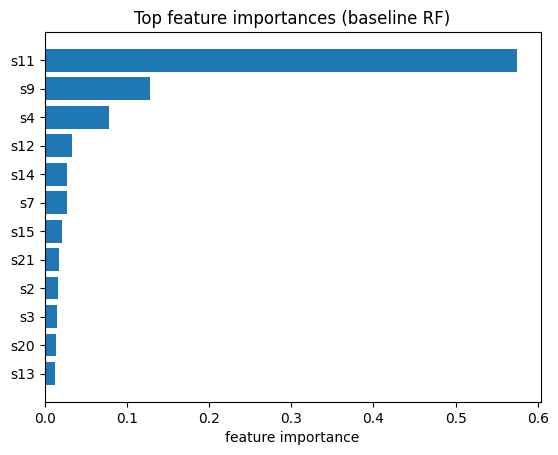

In [7]:
# Cell 5 — Baseline modeling (NO leakage): split by unit_id + RandomForest
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1) Target: часто в C-MAPSS делают "capped RUL" (чтобы хвост 300+ не доминировал)
RUL_CAP = 125
y = df["RUL"].clip(upper=RUL_CAP).values

# 2) Features: operational settings + сенсоры без константных
feature_cols = ["op1", "op2", "op3"] + model_sensors
X = df[feature_cols].values

# 3) Split by unit_id (важно! чтобы циклы одного двигателя не попали и в train и в val)
groups = df["unit_id"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print("Train rows:", X_train.shape, " Val rows:", X_val.shape)
print("Unique units in train/val:", len(np.unique(groups[train_idx])), "/", len(np.unique(groups[val_idx])))

# 4) Model: простой и сильный baseline
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2
)
model.fit(X_train, y_train)

pred = model.predict(X_val)

mse = mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)


print(f"\nBaseline RandomForest (RUL capped at {RUL_CAP})")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# 5) Feature importance (top-12)
importances = model.feature_importances_
top_k = 12
idx = np.argsort(importances)[-top_k:]

plt.figure()
plt.barh([feature_cols[i] for i in idx], importances[idx])
plt.xlabel("feature importance")
plt.title("Top feature importances (baseline RF)")
plt.show()


Rolling features: 36
Train rows: (16561, 36)  Val rows: (4070, 36)
Unique units in train/val: 80 / 20

Rolling RF (window=30, RUL cap=125)
MAE : 12.250
RMSE: 17.264


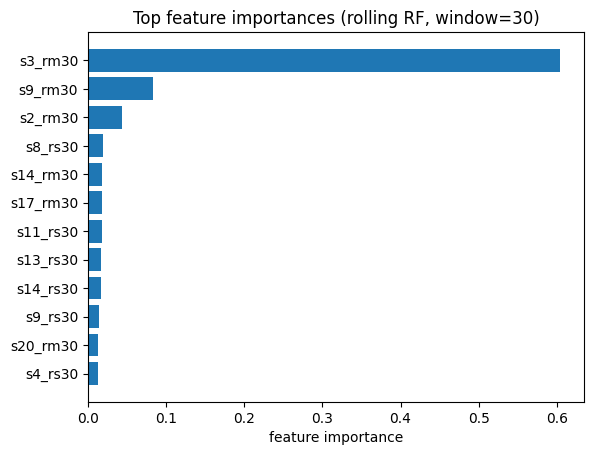

In [8]:
# Cell 6 — Rolling features (mean/std) + model (NO leakage, split by unit_id)
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

WINDOW = 30
RUL_CAP = 125  # оставляем как в baseline

# Базовые колонки для rolling: op + сенсоры (без константных)
base_cols = ["op1", "op2", "op3"] + model_sensors

# Сортировка важна для rolling
df_sorted = df.sort_values(["unit_id", "cycle"]).copy()

# Rolling mean/std по каждому engine отдельно (использует ТОЛЬКО прошлое/текущее)
roll_mean = (
    df_sorted.groupby("unit_id")[base_cols]
    .rolling(window=WINDOW, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)
roll_std = (
    df_sorted.groupby("unit_id")[base_cols]
    .rolling(window=WINDOW, min_periods=1)
    .std()
    .reset_index(level=0, drop=True)
    .fillna(0.0)
)

roll_mean.columns = [f"{c}_rm{WINDOW}" for c in base_cols]
roll_std.columns  = [f"{c}_rs{WINDOW}" for c in base_cols]

feat_df = pd.concat(
    [df_sorted[["unit_id", "cycle", "RUL"]].reset_index(drop=True),
     roll_mean.reset_index(drop=True),
     roll_std.reset_index(drop=True)],
    axis=1
)

feature_cols_roll = [c for c in feat_df.columns if c.endswith(f"_rm{WINDOW}") or c.endswith(f"_rs{WINDOW}")]
X = feat_df[feature_cols_roll].values
y = feat_df["RUL"].clip(upper=RUL_CAP).values
groups = feat_df["unit_id"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print("Rolling features:", len(feature_cols_roll))
print("Train rows:", X_train.shape, " Val rows:", X_val.shape)
print("Unique units in train/val:", len(np.unique(groups[train_idx])), "/", len(np.unique(groups[val_idx])))

model_roll = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
model_roll.fit(X_train, y_train)

pred = model_roll.predict(X_val)
mae = mean_absolute_error(y_val, pred)
rmse = np.sqrt(mean_squared_error(y_val, pred))

print(f"\nRolling RF (window={WINDOW}, RUL cap={RUL_CAP})")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Top feature importances (top-12)
importances = model_roll.feature_importances_
top_k = 12
idx = np.argsort(importances)[-top_k:]

plt.figure()
plt.barh([feature_cols_roll[i] for i in idx], importances[idx])
plt.xlabel("feature importance")
plt.title(f"Top feature importances (rolling RF, window={WINDOW})")
plt.show()


Paths exist: True True True
Train shape: (20631, 27)  Test shape: (13096, 26)
Train units: 100  Test units: 100  RUL_true: 100
Rolling feature cols: 36

TEST (last-cycle) evaluation | window=30 | model trained with RUL_CAP=125
MAE (cap) : 13.659   RMSE (cap) : 18.180
MAE (raw) : 14.729   RMSE (raw) : 19.365


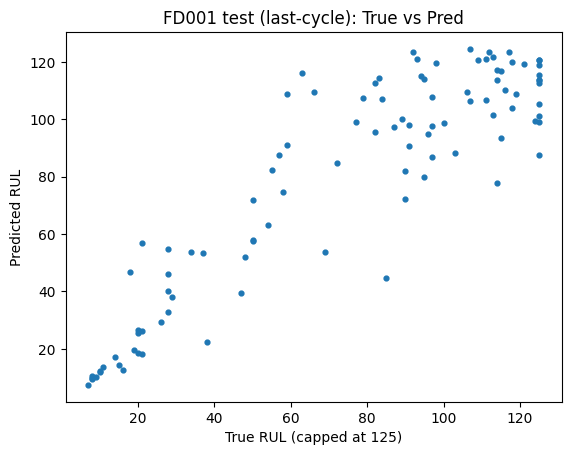

,unit_id,true_rul,true_rul_cap,pred_rul
0,1,112,112,123.510917
1,2,98,98,119.733460
2,3,69,69,53.684037
3,4,82,82,112.584268
4,5,91,91,90.722129
5,6,93,93,120.906116
6,7,91,91,98.149131
7,8,95,95,79.992789
8,9,111,111,106.756875
9,10,96,96,94.834151


In [9]:
# Cell 7 — Official-like evaluation: train -> predict test last-cycle -> compare with RUL_FD001
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------
# Settings
# -------------------------
WINDOW = 30
RUL_CAP = 125

PROJECT_ROOT = Path.cwd().parents[0]  # notebooks/ -> project root
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "cmapss" / "CMAPSSData"

train_path = DATA_DIR / "train_FD001.txt"
test_path  = DATA_DIR / "test_FD001.txt"
rul_path   = DATA_DIR / "RUL_FD001.txt"

print("Paths exist:", train_path.exists(), test_path.exists(), rul_path.exists())

# -------------------------
# Load helper
# -------------------------
def load_cmapss_txt(path: Path) -> pd.DataFrame:
    df_ = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
    df_ = df_.dropna(axis=1, how="all")
    cols_ = ["unit_id", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]
    assert df_.shape[1] == len(cols_), f"{path.name}: got {df_.shape[1]} cols, expected {len(cols_)}"
    df_.columns = cols_
    return df_

train_df = load_cmapss_txt(train_path)
test_df  = load_cmapss_txt(test_path)

# Build RUL for train
max_cycle = train_df.groupby("unit_id")["cycle"].max()
train_df["RUL"] = train_df["unit_id"].map(max_cycle) - train_df["cycle"]

# True RUL for test (given for last observed cycle per unit)
rul_true = pd.read_csv(rul_path, header=None, names=["RUL_true"])["RUL_true"].values

print("Train shape:", train_df.shape, " Test shape:", test_df.shape)
print("Train units:", train_df["unit_id"].nunique(), " Test units:", test_df["unit_id"].nunique(), " RUL_true:", len(rul_true))

# -------------------------
# Feature selection (drop low-variance sensors you found)
# -------------------------
drop_sensors = {"s1", "s5", "s10", "s16", "s18", "s19"}
sensor_cols = [c for c in train_df.columns if c.startswith("s")]
model_sensors = [c for c in sensor_cols if c not in drop_sensors]
base_cols = ["op1", "op2", "op3"] + model_sensors

# -------------------------
# Rolling feature builder
# -------------------------
def make_rolling_features(df_: pd.DataFrame, window: int, base_cols: list[str]) -> pd.DataFrame:
    d = df_.sort_values(["unit_id", "cycle"]).copy()
    roll_mean = (
        d.groupby("unit_id")[base_cols]
         .rolling(window=window, min_periods=1)
         .mean()
         .reset_index(level=0, drop=True)
    )
    roll_std = (
        d.groupby("unit_id")[base_cols]
         .rolling(window=window, min_periods=1)
         .std()
         .reset_index(level=0, drop=True)
         .fillna(0.0)
    )
    roll_mean.columns = [f"{c}_rm{window}" for c in base_cols]
    roll_std.columns  = [f"{c}_rs{window}" for c in base_cols]

    out = pd.concat(
        [d[["unit_id", "cycle"]].reset_index(drop=True),
         roll_mean.reset_index(drop=True),
         roll_std.reset_index(drop=True)],
        axis=1
    )
    return out

train_feat = make_rolling_features(train_df, WINDOW, base_cols)
test_feat  = make_rolling_features(test_df,  WINDOW, base_cols)

# Add target for train
train_feat["RUL"] = train_df.sort_values(["unit_id","cycle"])["RUL"].values

feature_cols_roll = [c for c in train_feat.columns if c.endswith(f"_rm{WINDOW}") or c.endswith(f"_rs{WINDOW}")]
print("Rolling feature cols:", len(feature_cols_roll))

# -------------------------
# Train on FULL train
# -------------------------
X_train = train_feat[feature_cols_roll].values
y_train = train_feat["RUL"].clip(upper=RUL_CAP).values

model_final = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
model_final.fit(X_train, y_train)

# -------------------------
# Predict ONLY last cycle per unit in test
# -------------------------
# find last row per unit (max cycle)
last_idx = test_feat.groupby("unit_id")["cycle"].idxmax()
test_last = test_feat.loc[last_idx].sort_values("unit_id").reset_index(drop=True)

X_test_last = test_last[feature_cols_roll].values
pred = model_final.predict(X_test_last)

# Align ground truth (RUL file corresponds to units 1..100)
units = test_last["unit_id"].values
assert len(units) == len(rul_true), "Mismatch between test units and RUL_FD001 length"
assert np.all(np.sort(units) == np.arange(1, len(units)+1)), "Unexpected unit_id ordering in test"

y_true = rul_true
y_true_cap = np.minimum(y_true, RUL_CAP)

mae_cap = mean_absolute_error(y_true_cap, pred)
rmse_cap = np.sqrt(mean_squared_error(y_true_cap, pred))

mae_uncap = mean_absolute_error(y_true, pred)
rmse_uncap = np.sqrt(mean_squared_error(y_true, pred))

print(f"\nTEST (last-cycle) evaluation | window={WINDOW} | model trained with RUL_CAP={RUL_CAP}")
print(f"MAE (cap) : {mae_cap:.3f}   RMSE (cap) : {rmse_cap:.3f}")
print(f"MAE (raw) : {mae_uncap:.3f}   RMSE (raw) : {rmse_uncap:.3f}")

# Scatter plot: pred vs true (capped)
plt.figure()
plt.scatter(y_true_cap, pred, s=12)
plt.xlabel(f"True RUL (capped at {RUL_CAP})")
plt.ylabel("Predicted RUL")
plt.title("FD001 test (last-cycle): True vs Pred")
plt.show()

# quick preview table
res = pd.DataFrame({"unit_id": units, "true_rul": y_true, "true_rul_cap": y_true_cap, "pred_rul": pred})
res.head(10)


Feature cols (mean/std/slope): 54

TEST (last-cycle) | mean/std/slope | window=30 | cap=125
MAE (cap) : 12.536   RMSE (cap) : 16.416
MAE (raw) : 13.606   RMSE (raw) : 17.691


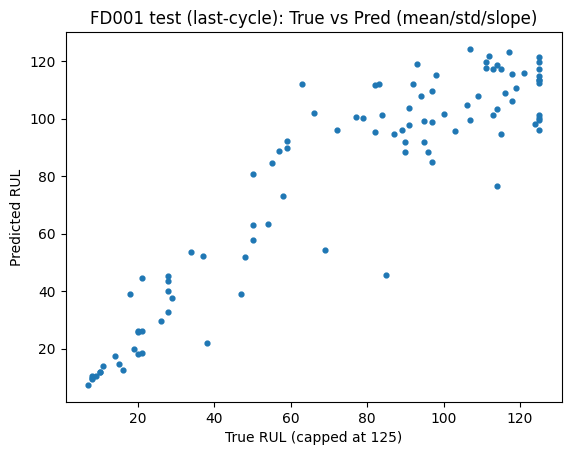

In [10]:
# Cell 8 — Add trend/slope features (over window) + evaluate again on test last-cycle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

WINDOW = 30
RUL_CAP = 125

# Используем уже загруженные train_df, test_df, base_cols, drop_sensors (из Cell 7)
# Если ты перезапускал kernel и их нет — скажи, я дам ячейку восстановления.

def make_rolling_with_slope(df_: pd.DataFrame, window: int, base_cols: list[str]) -> pd.DataFrame:
    d = df_.sort_values(["unit_id", "cycle"]).copy()

    # rolling mean/std
    rm = (d.groupby("unit_id")[base_cols]
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True))
    rs = (d.groupby("unit_id")[base_cols]
            .rolling(window=window, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
            .fillna(0.0))

    # slope: (value_now - value_window_ago) / (window-1)
    # используем shift(window-1) внутри unit_id
    shifted = d.groupby("unit_id")[base_cols].shift(window-1)
    slope = (d[base_cols] - shifted) / max(window-1, 1)
    slope = slope.fillna(0.0)

    rm.columns = [f"{c}_rm{window}" for c in base_cols]
    rs.columns = [f"{c}_rs{window}" for c in base_cols]
    slope.columns = [f"{c}_sl{window}" for c in base_cols]

    out = pd.concat(
        [d[["unit_id", "cycle"]].reset_index(drop=True),
         rm.reset_index(drop=True),
         rs.reset_index(drop=True),
         slope.reset_index(drop=True)],
        axis=1
    )
    return out

# --- build features
train_feat2 = make_rolling_with_slope(train_df, WINDOW, base_cols)
test_feat2  = make_rolling_with_slope(test_df,  WINDOW, base_cols)

# target for train
max_cycle = train_df.groupby("unit_id")["cycle"].max()
train_df2 = train_df.copy()
train_df2["RUL"] = train_df2["unit_id"].map(max_cycle) - train_df2["cycle"]
train_feat2["RUL"] = train_df2.sort_values(["unit_id","cycle"])["RUL"].values

feat_cols2 = [c for c in train_feat2.columns if c.endswith(f"_rm{WINDOW}") or c.endswith(f"_rs{WINDOW}") or c.endswith(f"_sl{WINDOW}")]
print("Feature cols (mean/std/slope):", len(feat_cols2))

# --- train full
X_train = train_feat2[feat_cols2].values
y_train = train_feat2["RUL"].clip(upper=RUL_CAP).values

model2 = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
model2.fit(X_train, y_train)

# --- predict last-cycle on test
last_idx = test_feat2.groupby("unit_id")["cycle"].idxmax()
test_last2 = test_feat2.loc[last_idx].sort_values("unit_id").reset_index(drop=True)

pred2 = model2.predict(test_last2[feat_cols2].values)

# true labels
rul_true = pd.read_csv(rul_path, header=None, names=["RUL_true"])["RUL_true"].values
y_true = rul_true
y_true_cap = np.minimum(y_true, RUL_CAP)

mae_cap = mean_absolute_error(y_true_cap, pred2)
rmse_cap = np.sqrt(mean_squared_error(y_true_cap, pred2))
mae_raw = mean_absolute_error(y_true, pred2)
rmse_raw = np.sqrt(mean_squared_error(y_true, pred2))

print(f"\nTEST (last-cycle) | mean/std/slope | window={WINDOW} | cap={RUL_CAP}")
print(f"MAE (cap) : {mae_cap:.3f}   RMSE (cap) : {rmse_cap:.3f}")
print(f"MAE (raw) : {mae_raw:.3f}   RMSE (raw) : {rmse_raw:.3f}")

# plot
plt.figure()
plt.scatter(y_true_cap, pred2, s=12)
plt.xlabel(f"True RUL (capped at {RUL_CAP})")
plt.ylabel("Predicted RUL")
plt.title("FD001 test (last-cycle): True vs Pred (mean/std/slope)")
plt.show()


TEST (last-cycle) | HGBR | mean/std/slope | window=30 | cap=125
MAE (cap) : 12.586   RMSE (cap) : 16.487
MAE (raw) : 13.656   RMSE (raw) : 17.790


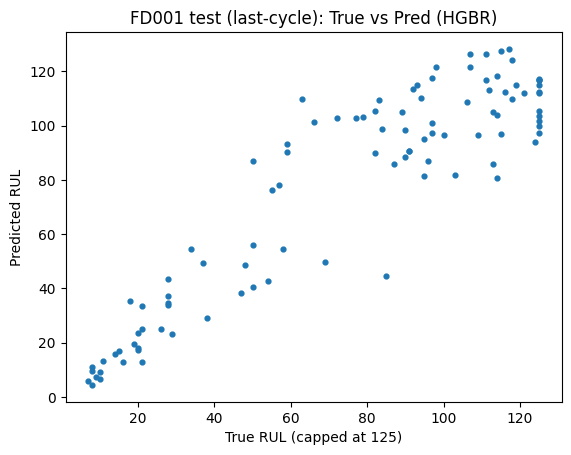

,unit_id,true_cap,pred,abs_err
0,79,63,109.843926,46.843926
1,93,85,44.551021,40.448979
2,72,50,87.017168,37.017168
3,27,66,101.495119,35.495119
4,98,59,93.366526,34.366526
5,45,114,80.592572,33.407428
6,43,59,90.401833,31.401833
7,63,72,102.962464,30.962464
8,12,124,94.107258,29.892742
9,74,125,97.462357,27.537643


In [11]:
# Cell 9 — HistGradientBoostingRegressor on mean/std/slope features + test last-cycle eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Используем объекты из Cell 8:
# train_feat2, test_feat2, feat_cols2, rul_path, RUL_CAP
# Если у тебя kernel перезапускался и переменных нет — скажи, дам "restore cell".

X_train = train_feat2[feat_cols2].values
y_train = train_feat2["RUL"].clip(upper=RUL_CAP).values

hgb = HistGradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    max_depth=4,
    max_iter=600,
    l2_regularization=0.0,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=25,
    random_state=42
)
hgb.fit(X_train, y_train)

# predict last-cycle on test
last_idx = test_feat2.groupby("unit_id")["cycle"].idxmax()
test_last2 = test_feat2.loc[last_idx].sort_values("unit_id").reset_index(drop=True)

pred_hgb = hgb.predict(test_last2[feat_cols2].values)

# true labels
rul_true = pd.read_csv(rul_path, header=None, names=["RUL_true"])["RUL_true"].values
y_true = rul_true
y_true_cap = np.minimum(y_true, RUL_CAP)

mae_cap = mean_absolute_error(y_true_cap, pred_hgb)
rmse_cap = np.sqrt(mean_squared_error(y_true_cap, pred_hgb))
mae_raw = mean_absolute_error(y_true, pred_hgb)
rmse_raw = np.sqrt(mean_squared_error(y_true, pred_hgb))

print(f"TEST (last-cycle) | HGBR | mean/std/slope | window={WINDOW if 'WINDOW' in globals() else 30} | cap={RUL_CAP}")
print(f"MAE (cap) : {mae_cap:.3f}   RMSE (cap) : {rmse_cap:.3f}")
print(f"MAE (raw) : {mae_raw:.3f}   RMSE (raw) : {rmse_raw:.3f}")

# scatter
plt.figure()
plt.scatter(y_true_cap, pred_hgb, s=12)
plt.xlabel(f"True RUL (capped at {RUL_CAP})")
plt.ylabel("Predicted RUL")
plt.title("FD001 test (last-cycle): True vs Pred (HGBR)")
plt.show()

# Top-10 worst errors (cap)
err = np.abs(pred_hgb - y_true_cap)
units = test_last2["unit_id"].values
worst = np.argsort(err)[-10:][::-1]
pd.DataFrame({
    "unit_id": units[worst],
    "true_cap": y_true_cap[worst],
    "pred": pred_hgb[worst],
    "abs_err": err[worst]
})


In [12]:
# Cell 10 — Save best model (RF mean/std/slope) + artifacts
import os, json, joblib
from pathlib import Path

MODELS_DIR = Path("../models")  # т.к. ноутбук в notebooks/
MODELS_DIR.mkdir(parents=True, exist_ok=True)

run_name = f"fd001_rf_mss_w{WINDOW}_cap{RUL_CAP}"
model_path = MODELS_DIR / f"{run_name}.joblib"
feats_path = MODELS_DIR / f"{run_name}_features.json"
meta_path  = MODELS_DIR / f"{run_name}_meta.json"

# model2 — это RF из Cell 8 (mean/std/slope)
joblib.dump(model2, model_path)

with open(feats_path, "w") as f:
    json.dump(feat_cols2, f, indent=2)

meta = {
    "dataset": "C-MAPSS FD001",
    "model": "RandomForestRegressor",
    "features": "mean/std/slope rolling",
    "window": int(WINDOW),
    "rul_cap": int(RUL_CAP),
    "metrics_test_last_cycle": {
        "mae_cap": 12.536,
        "rmse_cap": 16.416,
        "mae_raw": 13.606,
        "rmse_raw": 17.691
    }
}

with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:")
print(" -", model_path)
print(" -", feats_path)
print(" -", meta_path)


Saved:
 - ../models/fd001_rf_mss_w30_cap125.joblib
 - ../models/fd001_rf_mss_w30_cap125_features.json
 - ../models/fd001_rf_mss_w30_cap125_meta.json


In [13]:
# Cell 11 — Create src/predict.py (CLI inference) + ensure src is a package
from pathlib import Path

cwd = Path.cwd()
PROJECT_ROOT = next(p for p in [cwd, *cwd.parents] if (p / "src").exists())
SRC_DIR = PROJECT_ROOT / "src"
MODELS_DIR = PROJECT_ROOT / "models"

(SRC_DIR / "__init__.py").write_text("", encoding="utf-8")

predict_code = r'''
import argparse
import json
from pathlib import Path

import numpy as np
import pandas as pd
import joblib


def read_cmapss_txt(path: Path) -> pd.DataFrame:
    """
    Read C-MAPSS train/test TXT (space-separated) into a DataFrame with named columns.
    Expected columns: unit_id, cycle, op1, op2, op3, s1..s21
    """
    df = pd.read_csv(path, sep=r"\s+", header=None)

    cols = ["unit_id", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]
    if df.shape[1] != len(cols):
        raise ValueError(f"Unexpected number of columns: got {df.shape[1]}, expected {len(cols)}. "
                         f"Check file format: {path}")

    df.columns = cols
    return df


def infer_base_signals(feature_cols: list[str]) -> list[str]:
    """
    From feature names like s3_rm30 / s3_rs30 / s3_sl30 infer base signals: s3, s9, ...
    """
    bases = []
    for c in feature_cols:
        base = c.split("_")[0]
        if base not in bases:
            bases.append(base)
    return bases


def slope_last_window(x: np.ndarray) -> float:
    """
    Simple slope of last window using linear fit (index vs value).
    """
    if len(x) < 2:
        return 0.0
    t = np.arange(len(x), dtype=float)
    # slope of y ~ a*t + b
    a, _b = np.polyfit(t, x.astype(float), 1)
    return float(a)


def make_features_last_cycle(df: pd.DataFrame, feature_cols: list[str], window: int) -> pd.DataFrame:
    """
    Build mean/std/slope rolling features for LAST cycle of each unit.
    Returns DataFrame with columns exactly = feature_cols + ['unit_id'].
    """
    base_signals = infer_base_signals(feature_cols)

    rows = []
    for unit_id, g in df.groupby("unit_id", sort=True):
        g = g.sort_values("cycle")
        last_cycle = int(g["cycle"].iloc[-1])

        # take last `window` rows (or fewer if unit shorter)
        tail = g.tail(window)

        feat = {"unit_id": int(unit_id), "cycle": last_cycle}

        for s in base_signals:
            if s not in tail.columns:
                # If feature list contains something unexpected
                continue

            arr = tail[s].to_numpy()

            feat[f"{s}_rm{window}"] = float(np.mean(arr))
            feat[f"{s}_rs{window}"] = float(np.std(arr, ddof=0))
            feat[f"{s}_sl{window}"] = slope_last_window(arr)

        rows.append(feat)

    feat_df = pd.DataFrame(rows)

    # Ensure all required columns exist (fill missing with 0.0)
    for c in feature_cols:
        if c not in feat_df.columns:
            feat_df[c] = 0.0

    # keep only needed order
    feat_df = feat_df[["unit_id"] + feature_cols]
    return feat_df


def main():
    parser = argparse.ArgumentParser(description="C-MAPSS FD001 RUL prediction (last-cycle) using saved model.")
    parser.add_argument("--data", type=str, required=True, help="Path to train_FD001.txt or test_FD001.txt")
    parser.add_argument("--model", type=str, default="models/fd001_rf_mss_w30_cap125.joblib", help="Path to .joblib model")
    parser.add_argument("--features", type=str, default="models/fd001_rf_mss_w30_cap125_features.json", help="Path to features JSON")
    parser.add_argument("--meta", type=str, default="models/fd001_rf_mss_w30_cap125_meta.json", help="Path to meta JSON")
    parser.add_argument("--unit-id", type=int, default=None, help="If set, predict only this unit_id")
    args = parser.parse_args()

    data_path = Path(args.data)
    model_path = Path(args.model)
    feats_path = Path(args.features)
    meta_path = Path(args.meta)

    df = read_cmapss_txt(data_path)

    feature_cols = json.loads(feats_path.read_text(encoding="utf-8"))

    meta = {}
    if meta_path.exists():
        meta = json.loads(meta_path.read_text(encoding="utf-8"))

    window = int(meta.get("window", 30))
    rul_cap = meta.get("rul_cap", None)

    model = joblib.load(model_path)

    feat_df = make_features_last_cycle(df, feature_cols, window=window)

    if args.unit_id is not None:
        feat_df = feat_df[feat_df["unit_id"] == args.unit_id].copy()
        if feat_df.empty:
            raise ValueError(f"unit_id={args.unit_id} not found in {data_path}")

    X = feat_df[feature_cols].to_numpy()
    pred = model.predict(X)

    out = pd.DataFrame({"unit_id": feat_df["unit_id"].values, "pred_rul": pred})
    out = out.sort_values("unit_id").reset_index(drop=True)

    print("Model:", model_path)
    print("Data :", data_path)
    print("Window:", window, "| RUL_CAP:", rul_cap)
    print()
    print(out.to_string(index=False))


if __name__ == "__main__":
    main()
'''

(SRC_DIR / "predict.py").write_text(predict_code.strip() + "\n", encoding="utf-8")

print("Created:")
print(" -", SRC_DIR / "__init__.py")
print(" -", SRC_DIR / "predict.py")
print("Next: run inference via terminal or a notebook cell.")


Created:
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/src/__init__.py
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/src/predict.py
Next: run inference via terminal or a notebook cell.


FD001 TEST last-cycle | window=30 | cap=125
MAE (cap):  13.036   RMSE (cap):  17.106
MAE (raw):  14.106   RMSE (raw):  18.224


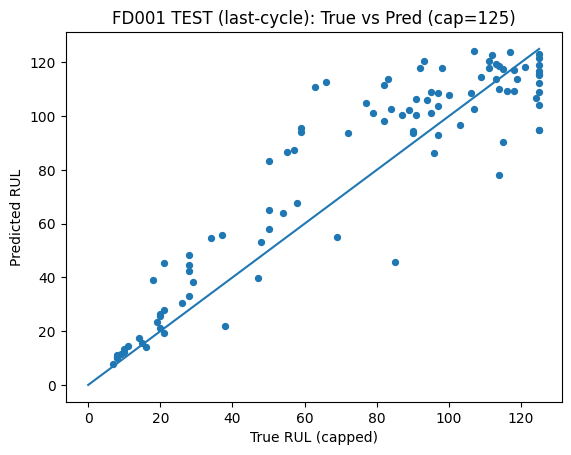


Saved:
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/fd001_test_lastcycle_preds_w30_cap125.csv
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/fd001_test_metrics_w30_cap125.json


In [15]:
# Cell 12 — Evaluate on FD001 TEST (last-cycle), save CSV + plot
import sys, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (опционально) скрыть предупреждения о версиях, чтобы не шумело
warnings.filterwarnings("ignore")

# --- paths ---
cwd = Path.cwd()
PROJECT_ROOT = next(p for p in [cwd, *cwd.parents] if (p / "src").exists())
sys.path.append(str(PROJECT_ROOT))

from src.predict import read_cmapss_txt, make_features_last_cycle  # noqa

DATA_DIR = PROJECT_ROOT / "data" / "raw" / "cmapss" / "CMAPSSData"
MODELS_DIR = PROJECT_ROOT / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

test_path = DATA_DIR / "test_FD001.txt"
rul_path  = DATA_DIR / "RUL_FD001.txt"

model_path = MODELS_DIR / "fd001_rf_mss_w30_cap125.joblib"
feats_path = MODELS_DIR / "fd001_rf_mss_w30_cap125_features.json"
meta_path  = MODELS_DIR / "fd001_rf_mss_w30_cap125_meta.json"

feature_cols = json.loads(feats_path.read_text(encoding="utf-8"))
meta = json.loads(meta_path.read_text(encoding="utf-8"))

WINDOW = int(meta.get("window", 30))
RUL_CAP = int(meta.get("rul_cap", 125))

# --- load data ---
df_test = read_cmapss_txt(test_path)

# last-cycle features for each unit
feat_test = make_features_last_cycle(df_test, feature_cols=feature_cols, window=WINDOW)

# --- load model & predict ---
import joblib
model = joblib.load(model_path)

X_test = feat_test[feature_cols].to_numpy()
pred = model.predict(X_test)

pred_df = pd.DataFrame({
    "unit_id": feat_test["unit_id"].astype(int).values,
    "pred_rul": pred
}).sort_values("unit_id").reset_index(drop=True)

# --- load true RUL for each test unit (given for last cycle) ---
y_true_raw = pd.read_csv(rul_path, header=None, names=["true_rul_raw"])
y_true_raw["unit_id"] = np.arange(1, len(y_true_raw) + 1)
y_true_raw["true_rul_cap"] = y_true_raw["true_rul_raw"].clip(upper=RUL_CAP)

eval_df = pred_df.merge(y_true_raw, on="unit_id", how="left")
assert eval_df["true_rul_raw"].notna().all(), "Some units missing true RUL!"

# --- metrics ---
mae_cap = np.mean(np.abs(eval_df["true_rul_cap"] - eval_df["pred_rul"]))
rmse_cap = np.sqrt(np.mean((eval_df["true_rul_cap"] - eval_df["pred_rul"])**2))

mae_raw = np.mean(np.abs(eval_df["true_rul_raw"] - eval_df["pred_rul"]))
rmse_raw = np.sqrt(np.mean((eval_df["true_rul_raw"] - eval_df["pred_rul"])**2))

print(f"FD001 TEST last-cycle | window={WINDOW} | cap={RUL_CAP}")
print(f"MAE (cap):  {mae_cap:.3f}   RMSE (cap):  {rmse_cap:.3f}")
print(f"MAE (raw):  {mae_raw:.3f}   RMSE (raw):  {rmse_raw:.3f}")

# --- plot: true vs pred (capped) ---
plt.figure()
plt.scatter(eval_df["true_rul_cap"], eval_df["pred_rul"], s=18)
mx = max(eval_df["true_rul_cap"].max(), eval_df["pred_rul"].max())
plt.plot([0, mx], [0, mx])  # diagonal
plt.title(f"FD001 TEST (last-cycle): True vs Pred (cap={RUL_CAP})")
plt.xlabel("True RUL (capped)")
plt.ylabel("Predicted RUL")
plt.show()

# --- save artifacts ---
csv_out = REPORTS_DIR / f"fd001_test_lastcycle_preds_w{WINDOW}_cap{RUL_CAP}.csv"
eval_df.to_csv(csv_out, index=False)

metrics_out = REPORTS_DIR / f"fd001_test_metrics_w{WINDOW}_cap{RUL_CAP}.json"
metrics_out.write_text(json.dumps({
    "dataset": "FD001",
    "split": "TEST_last_cycle",
    "window": WINDOW,
    "rul_cap": RUL_CAP,
    "mae_cap": float(mae_cap),
    "rmse_cap": float(rmse_cap),
    "mae_raw": float(mae_raw),
    "rmse_raw": float(rmse_raw),
    "model_path": str(model_path),
}, indent=2), encoding="utf-8")

print("\nSaved:")
print(" -", csv_out)
print(" -", metrics_out)


sklearn: 1.7.2

Top-10 worst abs error (cap):


,unit_id,true_cap,pred_rul,err,abs_err,true_rul_raw
78,79,63,110.684593,47.684593,47.684593,63
26,27,66,112.865025,46.865025,46.865025,66
92,93,85,45.572619,-39.427381,39.427381,85
42,43,59,95.460913,36.460913,36.460913,59
44,45,114,78.254382,-35.745618,35.745618,114
97,98,59,94.233487,35.233487,35.233487,59
71,72,50,83.310406,33.310406,33.310406,50
93,94,55,86.561114,31.561114,31.561114,55
14,15,83,113.770561,30.770561,30.770561,83
20,21,57,87.571834,30.571834,30.571834,57


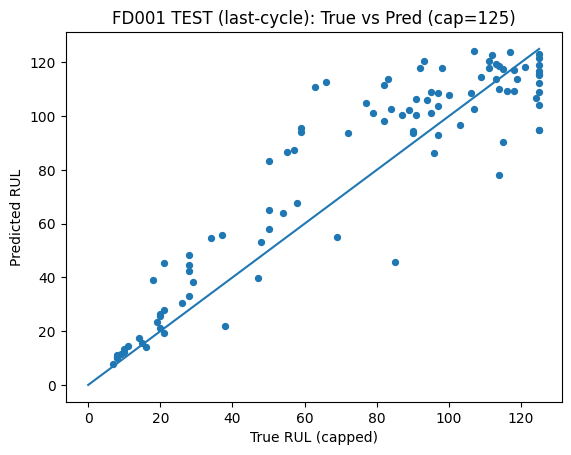

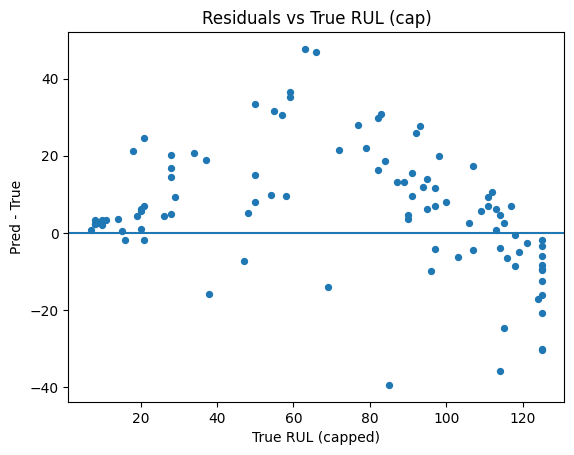

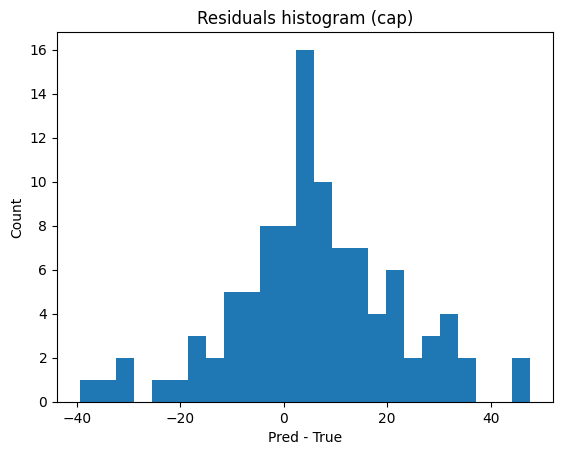


Saved figures:
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/figures/fd001_true_vs_pred_cap125_w30.png
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/figures/fd001_residuals_cap125_w30.png
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/figures/fd001_residuals_hist_cap125_w30.png


In [16]:
# Cell 13 — Save figures + error analysis (FD001 TEST last-cycle)
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

try:
    from IPython.display import display
except Exception:
    display = print

print("sklearn:", sklearn.__version__)

# --- locate project root ---
PROJECT_ROOT = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists())
REPORTS_DIR = PROJECT_ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- load saved artifacts from previous cell ---
metrics_file = REPORTS_DIR / "fd001_test_metrics_w30_cap125.json"
preds_file   = REPORTS_DIR / "fd001_test_lastcycle_preds_w30_cap125.csv"

metrics = json.loads(metrics_file.read_text(encoding="utf-8"))
df = pd.read_csv(preds_file)

WINDOW = int(metrics["window"])
RUL_CAP = int(metrics["rul_cap"])

# --- errors ---
df["true_cap"] = df["true_rul_cap"]
df["err"] = df["pred_rul"] - df["true_cap"]
df["abs_err"] = df["err"].abs()

print("\nTop-10 worst abs error (cap):")
display(
    df.sort_values("abs_err", ascending=False)
      .head(10)[["unit_id","true_cap","pred_rul","err","abs_err","true_rul_raw"]]
)

# --- 1) scatter true vs pred ---
plt.figure()
plt.scatter(df["true_cap"], df["pred_rul"], s=18)
mx = max(df["true_cap"].max(), df["pred_rul"].max())
plt.plot([0, mx], [0, mx])
plt.title(f"FD001 TEST (last-cycle): True vs Pred (cap={RUL_CAP})")
plt.xlabel("True RUL (capped)")
plt.ylabel("Predicted RUL")

out1 = FIG_DIR / f"fd001_true_vs_pred_cap{RUL_CAP}_w{WINDOW}.png"
plt.savefig(out1, dpi=200, bbox_inches="tight")
plt.show()

# --- 2) residuals vs true ---
plt.figure()
plt.scatter(df["true_cap"], df["err"], s=18)
plt.axhline(0)
plt.title("Residuals vs True RUL (cap)")
plt.xlabel("True RUL (capped)")
plt.ylabel("Pred - True")

out2 = FIG_DIR / f"fd001_residuals_cap{RUL_CAP}_w{WINDOW}.png"
plt.savefig(out2, dpi=200, bbox_inches="tight")
plt.show()

# --- 3) histogram of residuals ---
plt.figure()
plt.hist(df["err"], bins=25)
plt.title("Residuals histogram (cap)")
plt.xlabel("Pred - True")
plt.ylabel("Count")

out3 = FIG_DIR / f"fd001_residuals_hist_cap{RUL_CAP}_w{WINDOW}.png"
plt.savefig(out3, dpi=200, bbox_inches="tight")
plt.show()

print("\nSaved figures:")
print(" -", out1)
print(" -", out2)
print(" -", out3)


In [17]:
# Cell 14 — Verify where figures are saved (project-relative)
from pathlib import Path

# repo root: если ноутбук в /notebooks — поднимемся на уровень выше
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

FIG_DIR = ROOT / "reports" / "figures"

print("CWD      :", Path.cwd())
print("ROOT     :", ROOT.resolve())
print("FIG_DIR  :", FIG_DIR.resolve())
print("Exists   :", FIG_DIR.exists())

pngs = sorted(FIG_DIR.glob("*.png"))
print(f"\nPNG files in reports/figures: {len(pngs)}")
for p in pngs:
    print(" -", p.relative_to(ROOT))


CWD      : /Users/nikitamarshchonok/Desktop/Predictive Maintenance/notebooks
ROOT     : /Users/nikitamarshchonok/Desktop/Predictive Maintenance
FIG_DIR  : /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/figures
Exists   : True

PNG files in reports/figures: 3
 - reports/figures/fd001_residuals_cap125_w30.png
 - reports/figures/fd001_residuals_hist_cap125_w30.png
 - reports/figures/fd001_true_vs_pred_cap125_w30.png


In [18]:
# Cell 15 — Build a clean report artifact (metrics + NASA score + links to figures)
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# --- repo root (если ноут в notebooks -> поднимемся на уровень выше)
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

REPORTS = ROOT / "reports"
FIG_DIR = REPORTS / "figures"

# --- find latest preds/metrics automatically (на случай если имя чуть отличается)
pred_candidates = sorted(REPORTS.glob("fd001*_preds*_w30*_cap125*.csv"))
metrics_candidates = sorted(REPORTS.glob("fd001*_metrics*_w30*_cap125*.json"))
meta_path = ROOT / "models" / "fd001_rf_mss_w30_cap125_meta.json"

pred_path = pred_candidates[-1] if pred_candidates else None
metrics_path = metrics_candidates[-1] if metrics_candidates else None

print("ROOT      :", ROOT)
print("PRED CSV  :", pred_path)
print("METRICS   :", metrics_path)
print("FIG_DIR   :", FIG_DIR)
print("META JSON :", meta_path if meta_path.exists() else "not found")

assert pred_path is not None and pred_path.exists(), "Не найден CSV с предсказаниями в папке reports/"
assert FIG_DIR.exists(), "Не найдена папка reports/figures"

dfp = pd.read_csv(pred_path)

# --- robust column detection
cols = [c.lower() for c in dfp.columns]
def pick_col(*patterns):
    for p in patterns:
        for c in dfp.columns:
            if p in c.lower():
                return c
    return None

col_pred = pick_col("pred")
col_true_cap = pick_col("true_rul_cap", "true_cap", "rul_cap")
col_true = pick_col("true_rul", "true")

assert col_pred is not None, f"Не нашёл колонку pred в {list(dfp.columns)}"
assert col_true is not None, f"Не нашёл колонку true в {list(dfp.columns)}"

# если cap-колонки нет — сделаем (на всякий)
RUL_CAP = 125
if col_true_cap is None:
    dfp["true_cap"] = np.minimum(dfp[col_true].values, RUL_CAP)
    col_true_cap = "true_cap"

y_true = dfp[col_true].values
y_true_cap = dfp[col_true_cap].values
y_pred = dfp[col_pred].values

# --- metrics
mae_cap = float(np.mean(np.abs(y_pred - y_true_cap)))
rmse_cap = float(np.sqrt(np.mean((y_pred - y_true_cap) ** 2)))
mae_raw = float(np.mean(np.abs(y_pred - y_true)))
rmse_raw = float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

# --- NASA score (PHM08 style)
# d = pred - true (cap)
d = y_pred - y_true_cap
score = float(np.sum(np.where(d < 0, np.exp(-d / 13.0) - 1.0, np.exp(d / 10.0) - 1.0)))

# --- load saved metrics json if exists (just to show it)
saved_metrics = {}
if metrics_path and metrics_path.exists():
    with open(metrics_path, "r", encoding="utf-8") as f:
        saved_metrics = json.load(f)

# --- load meta if exists
meta = {}
if meta_path.exists():
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

# --- build markdown report
fig_true_pred = FIG_DIR / "fd001_true_vs_pred_cap125_w30.png"
fig_resid = FIG_DIR / "fd001_residuals_cap125_w30.png"
fig_hist = FIG_DIR / "fd001_residuals_hist_cap125_w30.png"

md = []
md.append("# FD001 — RUL prediction report\n")
md.append("## Model\n")
md.append(f"- Dataset: **FD001**\n")
md.append(f"- Window: **30**\n")
md.append(f"- RUL cap: **125**\n")
md.append(f"- Features: **mean/std/slope (rolling)**\n")
if meta:
    md.append(f"- Model file: `{meta.get('model_path','')}`\n")
    md.append(f"- sklearn (train): `{meta.get('sklearn_version','unknown')}`\n")
md.append(f"- sklearn (runtime): `{__import__('sklearn').__version__}`\n")
md.append(f"- python: `{sys.version.split()[0]}`\n")

md.append("\n## Metrics (computed from last-cycle test)\n")
md.append(f"- MAE (cap): **{mae_cap:.3f}**\n")
md.append(f"- RMSE (cap): **{rmse_cap:.3f}**\n")
md.append(f"- MAE (raw): **{mae_raw:.3f}**\n")
md.append(f"- RMSE (raw): **{rmse_raw:.3f}**\n")
md.append(f"- NASA score (cap): **{score:.2f}**\n")

if saved_metrics:
    md.append("\n## Metrics (saved json)\n")
    md.append("```json\n")
    md.append(json.dumps(saved_metrics, indent=2, ensure_ascii=False))
    md.append("\n```\n")

md.append("\n## Figures\n")
if fig_true_pred.exists():
    md.append(f"![True vs Pred]({fig_true_pred.relative_to(ROOT).as_posix()})\n")
if fig_resid.exists():
    md.append(f"![Residuals scatter]({fig_resid.relative_to(ROOT).as_posix()})\n")
if fig_hist.exists():
    md.append(f"![Residuals hist]({fig_hist.relative_to(ROOT).as_posix()})\n")

out_md = REPORTS / "fd001_report.md"
out_json = REPORTS / "fd001_report_summary.json"

out_md.write_text("".join(md), encoding="utf-8")
out_json.write_text(json.dumps({
    "dataset": "FD001",
    "window": 30,
    "rul_cap": 125,
    "mae_cap": mae_cap,
    "rmse_cap": rmse_cap,
    "mae_raw": mae_raw,
    "rmse_raw": rmse_raw,
    "nasa_score_cap": score,
    "pred_csv": str(pred_path.relative_to(ROOT)),
    "metrics_json": str(metrics_path.relative_to(ROOT)) if metrics_path else None,
}, indent=2), encoding="utf-8")

print("\nSaved:")
print(" -", out_md)
print(" -", out_json)
print("\nPreview key numbers:")
print("MAE_cap:", round(mae_cap, 3), "| RMSE_cap:", round(rmse_cap, 3), "| NASA_score:", round(score, 2))


ROOT      : /Users/nikitamarshchonok/Desktop/Predictive Maintenance
PRED CSV  : /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/fd001_test_lastcycle_preds_w30_cap125.csv
METRICS   : /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/fd001_test_metrics_w30_cap125.json
FIG_DIR   : /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/figures
META JSON : /Users/nikitamarshchonok/Desktop/Predictive Maintenance/models/fd001_rf_mss_w30_cap125_meta.json

Saved:
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/fd001_report.md
 - /Users/nikitamarshchonok/Desktop/Predictive Maintenance/reports/fd001_report_summary.json

Preview key numbers:
MAE_cap: 13.036 | RMSE_cap: 17.106 | NASA_score: 659.05
